In [1]:
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img,img_to_array,save_img
import numpy as np
import tensorflow as tf

In [2]:
base_image_path= '/home/user/Machine_Learning_4/photo2.jpg'
style_reference_image_path = keras.utils.get_file(
    "starry_night.jpg", origin="https://img-datasets.s3.amazonaws.com/starry_night.jpg")

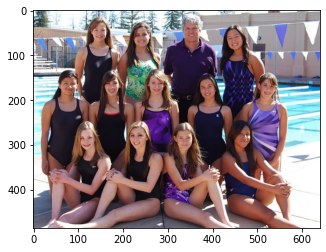

In [3]:
"""Content Image"""
plt.imshow(load_img(base_image_path))

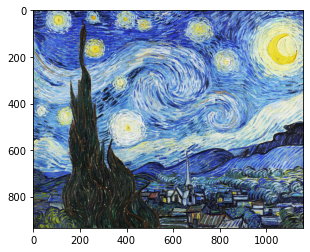

In [4]:
"""Style Reference Image"""
plt.imshow(load_img(style_reference_image_path))

In [5]:
original_width, original_height = load_img(base_image_path).size
img_height = 400
img_width = round(original_width * img_height / original_height)

In [6]:
def preprocess_image(image_path):
    img = load_img(
        image_path, target_size=(img_height, img_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = keras.applications.vgg19.preprocess_input(img)
    return img

def deprocess_image(img):
    img = img.reshape((img_height, img_width, 3))
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    img = img[:, :, ::-1]
    img = np.clip(img, 0, 255).astype("uint8")
    return img

In [7]:
"""Loading the pretrained VGG19 network and using it to define a feature extractor"""
S_Net = keras.applications.vgg19.VGG19(weights="imagenet", include_top=False)

outputs_dict = dict([(layer.name, layer.output) for layer in S_Net.layers])
feature_extractor = keras.Model(inputs=S_Net.inputs, outputs=outputs_dict)

In [8]:
S_Net.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [9]:
"""Content Loss"""
def content_loss(base_img, combination_img):
    return tf.reduce_sum(tf.square(combination_img - base_img))

In [10]:
"""Style Loss"""
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

def style_loss(style_img, combination_img):
    S = gram_matrix(style_img)
    C = gram_matrix(combination_img)
    channels = 3
    size = img_height * img_width
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

In [11]:
def total_variation_loss(x):
    a = tf.square(
        x[:, : img_height - 1, : img_width - 1, :] - x[:, 1:, : img_width - 1, :]
    )
    b = tf.square(
        x[:, : img_height - 1, : img_width - 1, :] - x[:, : img_height - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

In [12]:
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
content_layer_name = "block5_conv2"
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)
    loss = tf.zeros(shape=())
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        style_loss_value = style_loss(
          style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * style_loss_value

    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

In [ ]:


@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 4000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 100 == 0:
        print(f"Iteration {i}: loss={loss:.2f}")
        img = deprocess_image(combination_image.numpy())
        fname = f"combination_image_at_iteration_{i}.png"
        save_img(fname, img)

Iteration 100: loss=9182.33
Iteration 200: loss=7805.49
Iteration 300: loss=7193.47
Iteration 400: loss=6821.83
Iteration 500: loss=6562.41
Iteration 600: loss=6366.12
Iteration 700: loss=6210.15
Iteration 800: loss=6081.66
Iteration 900: loss=5973.34
Iteration 1000: loss=5880.50
Iteration 1100: loss=5799.72
Iteration 1200: loss=5729.11
Iteration 1300: loss=5666.69
Iteration 1400: loss=5611.22
Iteration 1500: loss=5561.55
Iteration 1600: loss=5516.80
Iteration 1700: loss=5476.24
Iteration 1800: loss=5439.39
Iteration 1900: loss=5405.84
Iteration 2000: loss=5375.12
Iteration 2100: loss=5346.88
Iteration 2200: loss=5320.92
Iteration 2300: loss=5296.98
Iteration 2400: loss=5274.79
Iteration 2500: loss=5254.23
Iteration 2600: loss=5235.14
Iteration 2700: loss=5217.37
Iteration 2800: loss=5200.81
Iteration 2900: loss=5185.38
